In [1]:
import pandas as pd
import numpy as np
import magic
from matplotlib import pyplot as plt
import seaborn as sns
import importlib
%matplotlib inline
importlib.reload(magic)
import seaborn as sns
from xgboost import XGBClassifier,XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [10]:
csv_file = 'future.csv'
take_only = 'Futurer'


data = pd.read_csv(csv_file)
data['tournament'] = data.tournament_scores/data.num_players
data['effectiveness'] = np.log(data.scores+1)/np.log(data.map_rivers_count/data.num_players)
data['density'] = np.log(data.map_rivers_count)/np.log(data.map_sites_count)
data['is_winner'] = data.ranking==0
print(data.server_name.unique())
if take_only is not None:
    data = data.loc[data.server_name == take_only,:]

params = [column for column in data.columns if column.startswith('param')]
major = ['density','num_players']
data = data.loc[data.num_players<=4]
print(data.shape)


['Futurer' 'LochKillerAi' 'ConnectClosestMinesAi']
(1800, 16)


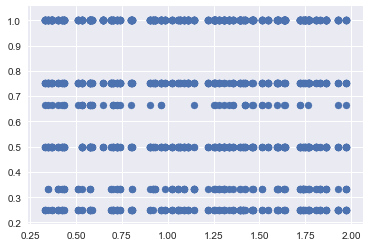

In [12]:
plt.scatter(data.param1,data.tournament)

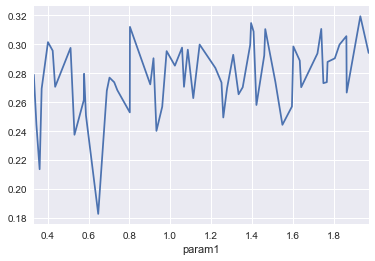

In [19]:
data.groupby('param1').std().tournament.plot()


In [3]:
len(data.name.unique())

60

In [4]:

model = XGBRegressor()
print(cross_val_score( model, data[major], data.tournament, scoring='neg_mean_absolute_error'))
print(cross_val_score( model, data[major+params], data.tournament, scoring='neg_mean_absolute_error'))

print(cross_val_score( model, data[major], data.effectiveness, scoring='neg_mean_absolute_error'))
print(cross_val_score( model, data[major+params], data.effectiveness, scoring='neg_mean_absolute_error'))

[-0.23619282 -0.23234131 -0.23927598]
[-0.24120822 -0.2338546  -0.24174853]
[-0.06415843 -0.06624062 -0.06292723]
[-0.0663506  -0.06690985 -0.0622747 ]


D:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


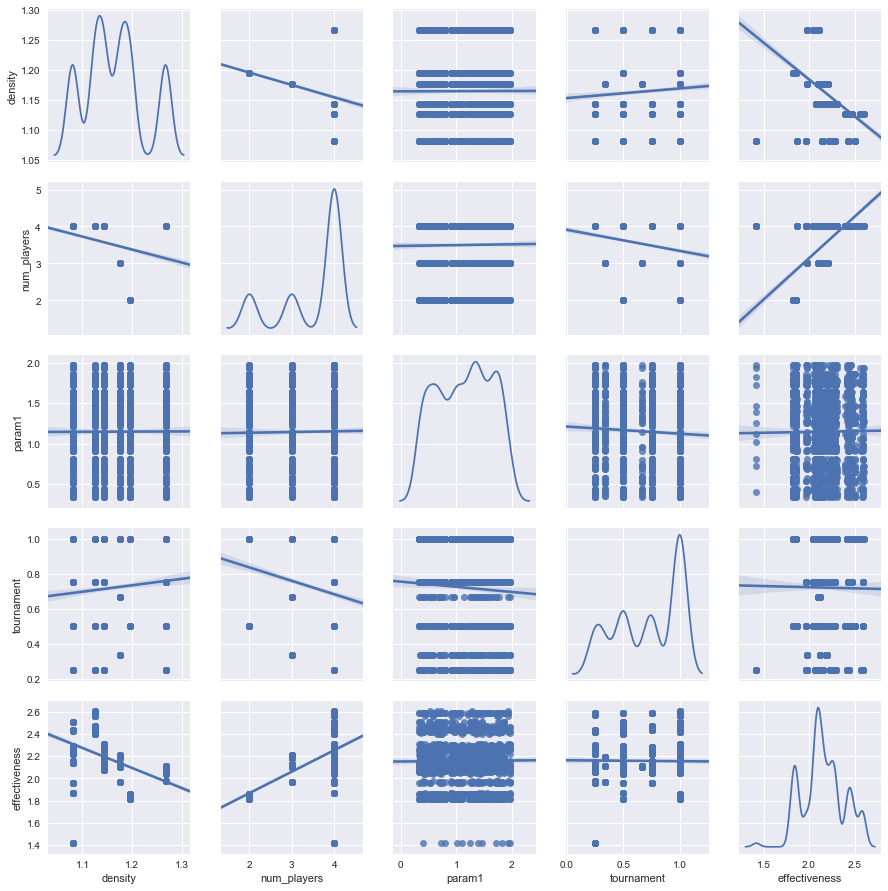

In [8]:
sns.pairplot(data, vars = major + params + ['tournament','effectiveness'],  
             kind='reg',
            diag_kind='kde',
            plot_kws={ 'scatter_kws' : {'alpha' : 0.8}})

In [6]:

test = data.loc[:  , major+params+['game_number','ranking']]
test = pd.merge(left=test,right=test,left_on='game_number',right_on='game_number',how='inner')
test = test.loc[test.ranking_x!=test.ranking_y]
test['x_wins'] = np.where(test.ranking_x<test.ranking_y,1,0)

features = [p+"_"+l for p in params for l in ['x','y']] + [p+"_x" for p in major]


TypeError: 'AxesSubplot' object does not support indexing

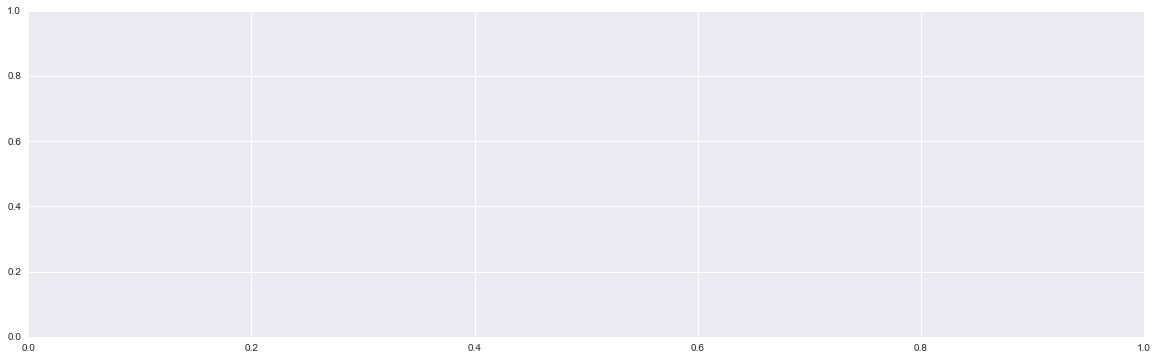

In [7]:
fix, ax = plt.subplots(1,len(params),figsize=(20,6))
for index, param in enumerate(params):
    grs = test.groupby([param+'_x',param+'_y']).mean()['x_wins'].reset_index()
    ax[index].scatter(grs[param+"_x"],grs[param+"_y"],c=grs.x_wins)

In [ ]:
model = XGBClassifier()
model.fit(test[features],test.x_wins)

In [ ]:
list(zip(features,model.feature_importances_))


In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(XGBClassifier(),test[features],test.x_wins)